In [90]:

# import packages
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import pickle

import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from skimage.filters import hessian, median
from sklearn.metrics import classification_report

In [25]:
#get labels

labels = pd.read_csv('./dataset/label.csv')

test_labels = pd.read_csv('./test/label.csv')

#get images from file name
def fetch_cv_image(row_id, root = "./dataset/image/"):
    file_name = f"IMAGE_{str.zfill(str(row_id), 4)}.jpg"
    file_path = os.path.join(root, file_name)
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return gray

In [26]:
#get images from file name
def fetch_image(row_id, root = "./dataset/image/"):
    file_name = f"IMAGE_{str.zfill(str(row_id), 4)}.jpg"
    file_path = os.path.join(root, file_name)
    img = Image.open(file_path)
    return np.array(img)

print(labels.label)

0       meningioma_tumor
1               no_tumor
2       meningioma_tumor
3           glioma_tumor
4       meningioma_tumor
              ...       
2995            no_tumor
2996    meningioma_tumor
2997        glioma_tumor
2998        glioma_tumor
2999     pituitary_tumor
Name: label, Length: 3000, dtype: object


In [85]:
def glcm_features(image):
    contrast_arr = []
    dis_arr = []
    hom_arr = [] 
    asm_arr = []
    cor_arr =[]

    # generate patches of size 7 by 7
    total_patches = np.lib.stride_tricks.sliding_window_view(image, (7,7))
    
    set_patches = total_patches[::50]
    
    for patches in set_patches:
        for patch in patches:
            # glcm features
            g = greycomatrix(patch, [5], [0, np.pi/2], levels=256)
            contrast_arr.append(greycoprops(g, 'contrast')[0,0]) 
            dis_arr.append(greycoprops(g, 'dissimilarity')[0,0])
            hom_arr.append(greycoprops(g, 'homogeneity')[0,0])
            asm_arr.append(greycoprops(g, 'ASM')[0,0])
            cor_arr.append(greycoprops(g, 'correlation')[0,0])

    return contrast_arr, dis_arr, hom_arr, asm_arr, cor_arr



In [86]:


def create_features(img):
    # convert image to greyscale
    grey_image = cv2.resize(rgb2gray(img), (256, 256), cv2.INTER_AREA)
    
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(64, 64))
    
    # pass through hessian filter for edge detection
    grey_image = hessian(grey_image)
    
    # normalize to 0-255 range
    norm_image = cv2.normalize(grey_image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    
    contrast, dis, hom, asm, cor = glcm_features(norm_image)

    features = np.hstack((contrast, dis, hom, asm, cor))
    return features

print(create_features(fetch_image(1)).shape)

/var/folders/9n/9yl6s2ns6rz7pg5ylpv58l500000gn/T/ipykernel_40912/228583669.py:8: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  grey_image = hessian(grey_image)


(6250,)


In [42]:
# create new column for labels: tumor if patient has cancer no tumor if not for binary classification

labels.loc[labels.label != "no_tumor", "cancer"] = 'tumor'
test_labels.loc[labels.label != "no_tumor", "cancer"] = 'tumor'

labels.loc[labels.label == "no_tumor", "cancer"] = 'no_tumor'
test_labels.loc[labels.label == "no_tumor", "cancer"] = 'no_tumor'

labels.head()

,file_name,label,cancer
0,IMAGE_0000.jpg,meningioma_tumor,tumor
1,IMAGE_0001.jpg,no_tumor,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor,tumor
3,IMAGE_0003.jpg,glioma_tumor,tumor
4,IMAGE_0004.jpg,meningioma_tumor,tumor



def create_sift_features(img):
    # create sift object
    sift = cv2.SIFT.create(nfeatures = 500)
    kp, des = sift.detectAndCompute(img, None)
    return kp,des.flatten()

kp1, des1 = create_sift_features(fetch_cv_image(5))
feature_length = des1.shape[0]

print(des1.shape)

min_length = float('inf')
for id in labels.index:
    _, des = create_sift_features(fetch_cv_image(id))
    min_length = min(min_length, des.shape[0])

print(min_length)
    

def combine_features(labels):
    features = np.empty((0, min_length), int)
    
    for img_id in labels.index:
        # load image
        img = fetch_cv_image(img_id)
        # get features for image
        image_features = create_sift_features(img)[1][:min_length]
        features = np.vstack([features,image_features])
        
    return features

feature_matrix = combine_features(labels)

print(feature_matrix.shape)

In [32]:
def combine_hog_features(labels):
    features = np.empty((0, create_features(fetch_image(1)).shape[0]), int)
    
    for img_id in labels.index:
        # load image
        img = fetch_image(img_id)
        # get features for image
        image_features = create_features(img)
        features = np.vstack([features,image_features])
        
    return features

def combine_test_hog_features(labels):
    features = np.empty((0, create_features(fetch_image(1)).shape[0]), int)
    
    for img_id in labels.index:
        # load image
        img = fetch_image(img_id, root = "./test/image/")
        # get features for image
        image_features = create_features(img)
        features = np.vstack([features,image_features])
        
    return features
hog_feature_matrix = combine_hog_features(labels)
test_hog_feature_matrix = combine_test_hog_features(test_labels)

/var/folders/9n/9yl6s2ns6rz7pg5ylpv58l500000gn/T/ipykernel_40912/3251298094.py:8: FutureWarning: Previously, hessian implicitly used 'constant' as the border mode when dealing with the edge of the array. The new behavior is 'reflect'. To recover the old behavior, use mode='constant'. To avoid this warning, please explicitly set the mode.
  grey_image = hessian(grey_image)


In [52]:

ss = StandardScaler()

# standardize scale of features
scaled_features = ss.fit_transform(hog_feature_matrix)

scaled_test_features = ss.fit_transform(test_hog_feature_matrix)

pca = PCA(n_components=200)

# reduce dimensions
pca_features = pca.fit_transform(scaled_features)

pca_test_features = pca.fit_transform(scaled_test_features)



In [53]:

X = pd.DataFrame(pca_features)
y = pd.Series(labels.cancer.values)
newX = pd.DataFrame(pca_test_features)
newY = pd.DataFrame(test_labels.cancer.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123, shuffle = True)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()
pd.Series(y_test).value_counts()

print(X.shape)

print(y.head())

(3000, 200)
0       tumor
1    no_tumor
2       tumor
3       tumor
4       tumor
dtype: object


In [44]:
def KNNClassifier(X_train, y_train, X_test):
    grid_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric':['euclidean', 'manhattan']}
    #Create KNN object with a K coefficient
    model = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1)
    model.fit(X_train, y_train) # Fit KNN model


    y_pred = model.predict(X_test)
    return y_pred, model

y_pred, model=KNNClassifier(X_train, y_train, X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Model accuracy is:  0.9533333333333334


In [94]:

newY_pred = model.best_estimator_.predict(newX)
accuracy = accuracy_score(newY, newY_pred)
print('Model accuracy on test dataset is: ', accuracy)

Model accuracy on test dataset is:  0.82


In [45]:
model.best_params_

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

In [46]:
filename = './models/binary_model.sav'
pickle.dump(model, open(filename, 'wb'))

Confusion matrix, without normalization
[[117  18]
 [ 24 741]]
Normalized confusion matrix
[[0.86666667 0.13333333]
 [0.03137255 0.96862745]]


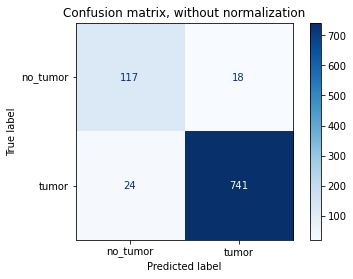

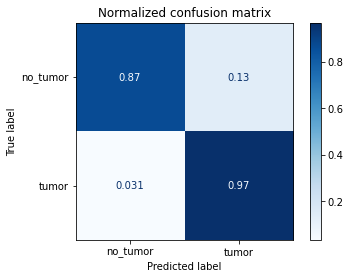

In [47]:

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=['no_tumor', 'tumor'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

Confusion matrix, without normalization
[[  2  16]
 [ 20 162]]
Normalized confusion matrix
[[0.11111111 0.88888889]
 [0.10989011 0.89010989]]


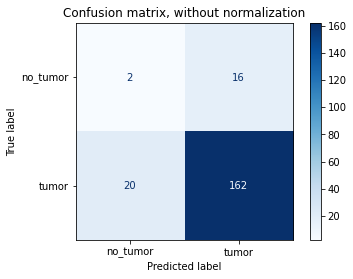

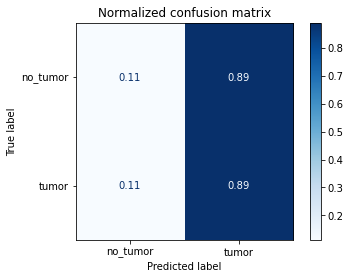

In [95]:

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        newX,
        newY,
        display_labels=['no_tumor', 'tumor'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

In [48]:
def SVMclassifier(X_train, y_train, X_test): 
    # create a parameter grid to perform search on
    param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
    # define support vector classifier
    svm = SVC(probability=True)

    model2 = GridSearchCV(svm, param_grid)
    # fit model
    model2.fit(X_train, y_train)
    # generate predictions
    y_pred = model.predict(X_test)
    
    return model2, y_pred

# calculate accuracy
model2, y_pred = SVMclassifier(X_train, y_train, X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)


Model accuracy is:  0.9533333333333334


In [87]:
print(model2.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'poly'}


In [54]:

newY_pred = model2.predict(newX)
accuracy = accuracy_score(newY, newY_pred)
print('Model accuracy on test dataset is: ', accuracy)

Model accuracy on test dataset is:  0.795


              precision    recall  f1-score   support

    no_tumor       0.13      0.22      0.16        18
       tumor       0.92      0.85      0.88       182

    accuracy                           0.80       200
   macro avg       0.52      0.54      0.52       200
weighted avg       0.85      0.80      0.82       200

Confusion matrix, without normalization
[[  4  14]
 [ 27 155]]
Normalized confusion matrix
[[0.22222222 0.77777778]
 [0.14835165 0.85164835]]


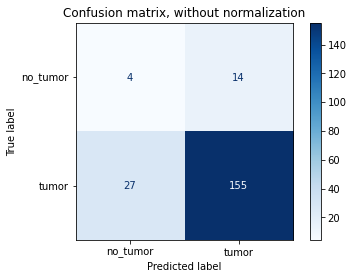

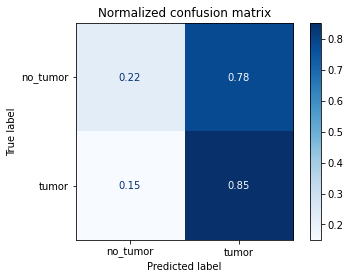

In [93]:

print(classification_report(newY, newY_pred, target_names=['no_tumor', 'tumor']))

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model2,
        newX,
        newY,
        display_labels=['no_tumor', 'tumor'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

Confusion matrix, without normalization
[[118  17]
 [ 15 750]]
Normalized confusion matrix
[[0.87407407 0.12592593]
 [0.01960784 0.98039216]]


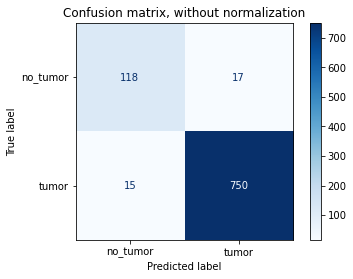

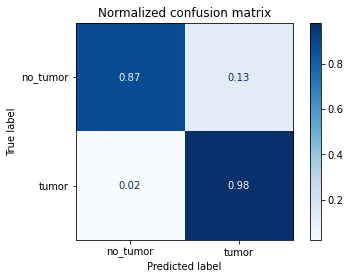

In [49]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model2,
        X_test,
        y_test,
        display_labels=['no_tumor', 'tumor'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

In [88]:

cv = KFold(n_splits=10, shuffle=False)
r_scores = []

for train_idx, test_idx in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    clf = model2.best_estimator_
    clf.fit(X_train, y_train)
    r_scores.append(clf.score(X_test, y_test))

print(r_scores)
    

[0.9766666666666667, 0.9633333333333334, 0.96, 0.9633333333333334, 0.9666666666666667, 0.97, 0.9633333333333334, 0.9733333333333334, 0.97, 0.9766666666666667]


In [50]:
def ForestCLF(X_train, y_train, X_test):
    
    clf = RandomForestClassifier(n_estimators = 500, max_depth=20, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return clf, y_pred

forest, y_pred = ForestCLF(X_train, y_train, X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy is: {accuracy}')

The accuracy is: 0.9366666666666666


Confusion matrix, without normalization
[[ 80  55]
 [  2 763]]
Normalized confusion matrix
[[0.59259259 0.40740741]
 [0.00261438 0.99738562]]


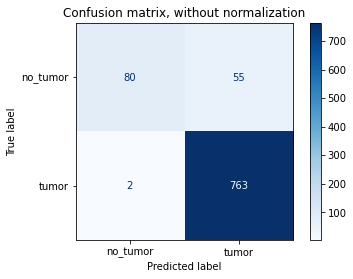

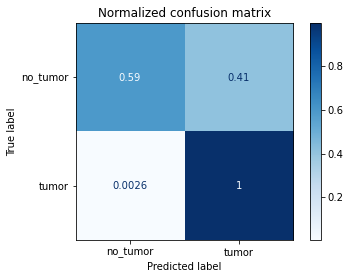

In [51]:

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        forest,
        X_test,
        y_test,
        display_labels=['no_tumor', 'tumor'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)


In [ ]:

cv = KFold(n_splits=10, shuffle=False)
r_scores = []

for train_idx, test_idx in cv.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    clf = RandomForestClassifier(n_estimators = 500, max_depth=20, random_state=0)
    clf.fit(X_train, y_train)
    r_scores.append(clf.score(X_test, y_test))
    

In [ ]:
print(r_scores)

[0.9366666666666666, 0.9033333333333333, 0.9233333333333333, 0.9033333333333333, 0.92, 0.91, 0.9166666666666666, 0.92, 0.92, 0.92]
